In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

from matplotlib.pyplot import figtext

plt.rcParams['text.usetex'] = True


In [4]:
%matplotlib inline

plt.style.use('fivethirtyeight')

In [5]:
from functools import wraps


def auto_save(dpi: int = 600):
    def decorator(fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            figure = fn(*args, **kwargs)
            figure.savefig(f'figures/{fn.__name__}', bbox_inches='tight', dpi=dpi)
            return figure

        return wrapper

    return decorator

In [6]:
import os

os.getcwd()

'/home/terry/Documents/Subjects/IBNotes/IAProjects/EE/jump/sims'

In [7]:
# vector ops
def vec_dot(a, b):
    return a[0] * b[0] + a[1] * b[1]


def vec_add(a, b):
    return [a[0] + b[0], a[1] + b[1]]


def vec_scale(a, c):
    return [a[0] * c, a[1] * c]


In [8]:
import math
from scipy.integrate import quad


# helper functions
def derivative(y, dx=1e-5):
    def d(x):
        return (y(x + dx) - y(x - dx)) / 2 / dx

    return d


def taylor_estimate(y, a, b, tolerance=0.1, limit=20):
    alpha = (a + b) / 2
    derivs = [y]
    derivs_a = [y(alpha)]

    for n in range(limit):
        derivs.append(derivative(derivs[-1]))
        derivs_a.append(derivs[-1](alpha) / math.factorial(n + 1))

        def taylor(x):
            total = 0
            for i, d in enumerate(derivs_a):
                total += d * (x - alpha) ** i

            return total

        # test from a to b, if integral larger than tolerance
        def squared_remainder(x):
            return (y(x) - taylor(x)) ** 2

        value, err = quad(squared_remainder, a, b)
        if value <= tolerance:
            return taylor, derivs_a

    raise Exception(f"out of limit, try increasing the limit above '{limit}'")


def xsquared(x):
    return math.sin(x)


def plot_function(f, a, b, dx=0.01):
    xs = np.arange(a, b, dx)
    ys = [f(x) for x in xs]
    plt.plot(xs, ys)


# tx, _ = taylor_estimate(xsquared, -2, 2)
# plot_function(xsquared, -5, 5)
# plot_function(tx, -5, 5)
# plt.show()

def numerical_integrate(y, a, b, tolerance=0.1, limit=20):
    alpha = (a + b) / 2
    _, coef = taylor_estimate(y, a, b, tolerance, limit)

    # new coefs after 1
    coefs_new = []
    for i, c in enumerate(coef):
        coefs_new.append(c / (i + 1))

    def F(x):
        total = coefs_new[0] * x
        for i, c in enumerate(coefs_new[1:]):
            total += c * (x - alpha) ** (i + 2)
        return total

    return F

# tx, _ = taylor_estimate(xsquared, -2, 2)
# # plot_function(xsquared, -5, 5)
# plot_function(lambda x: -math.cos(x), -5, 5)
#
# n = numerical_integrate(xsquared, -2, 2)
# plot_function(n, -5, 5)
# plt.show()


In [9]:
# this is the simulation code
default_j = (-800, 250, 10, [0, 250])


def air_time_continuous(g, v0=280):
    return -2 * v0 / g


def integral(f):
    def F(x):
        res, err = quad(f, 0, x)
        return res

    return F


def air_time_discrete(g, tau, v0=280):
    height = 0.0001
    vel_height = v0

    t = 0
    while height > 0:
        height = height + vel_height * tau + 0.5 * g * tau ** 2
        vel_height = vel_height + g * tau
        t += tau

    return t


# uses equations, no constraint
def simulate_no_constraint_continuous(a, j=None):
    if j is None:
        j = default_j
    g, l, A, v0 = j

    def acc_x(t):
        return a(t)[0]

    def acc_y(t):
        return a(t)[1]

    tf = air_time_continuous(g)

    # no *dt, coz continuous
    w = l * A

    vel_x = integral(acc_x)
    vel_y = integral(acc_y)
    pos_x = integral(vel_x)
    pos_y = integral(vel_y)

    return [
        w * pos_x(tf) + tf * (v0[0] - w * vel_x(0)) - w * pos_x(0),
        w * pos_y(tf) + tf * (v0[1] - w * vel_y(0)) - w * pos_y(0)
    ]


def simulate_no_constraint_discrete(a, j=None):
    if j is None:
        j = default_j
    g, l, A, v0 = j

    # SAME AS WITH THE CONSTRAINT
    dt = 1 / 64

    # variables
    height = 0.0001
    vel_height = 280

    data = []

    pos = [0, 0]
    vel = v0
    acc = [0, 0]
    t = 0
    while height > 0:
        data.append([t, *pos])

        # update gravity
        height = height + vel_height * dt + 0.5 * g * dt ** 2
        vel_height = vel_height + g * dt

        # no friction here

        # update velocity
        acc = a(t)

        # always max
        gamma1 = l * A * dt
        w = gamma1

        vel = vec_add(vel, vec_scale(acc, w))

        # update position
        pos = vec_add(pos, vec_scale(vel, dt))

        t += dt

    return pos, data


# use small dt, with constraint on dt, assuming continuous time
def simulate_continuous(a, j=None):
    if j is None:
        j = default_j
    g, l, A, v0 = j

    tf = air_time_continuous(g)

    # use a very small dt here, not using equation
    dt = 0.00001

    # variables
    pos = [0, 0]
    vel = v0
    acc = [0, 0]
    for t in np.arange(0, tf + 0.0001, dt):
        acc = a(t)

        gamma1 = l * A * dt
        gamma2 = l - vec_dot(vel, acc)

        # get w
        w = 0
        if 0 >= gamma2:
            w = 0
        elif gamma1 > gamma2 > 0:
            w = gamma2
        elif gamma2 >= gamma1:
            w = gamma1

        vel = vec_add(vel, vec_scale(acc, w))
        pos = vec_add(pos, vec_scale(vel, dt))

    return pos


# use 1/64, exact game code
def simulate_discrete(a, j=None):
    if j is None:
        j = (-800, 250, 10, [0, 250])
    g, l, A, v0 = j

    # use a very small dt here, not using equation
    dt = 1 / 64

    # variables
    height = 0.00001
    vel_height = 280

    data = []

    pos = [0, 0]
    vel = v0
    acc = [0, 0]
    t = 0
    while height > 0:
        data.append([t, *pos])

        # update gravity
        height = height + vel_height * dt + 0.5 * g * dt ** 2
        vel_height = vel_height + g * dt

        # no friction here

        # update velocity
        acc = a(t)

        gamma1 = l * A * dt
        gamma2 = l - vec_dot(vel, acc)

        w = 0
        if 0 >= gamma2:
            w = 0
        elif gamma1 > gamma2 > 0:
            w = gamma2
        elif gamma2 >= gamma1:
            w = gamma1

        vel = vec_add(vel, vec_scale(acc, w))

        # update position
        pos = vec_add(pos, vec_scale(vel, dt))

        t += dt

    return pos, data


def constraint_continuous(a, j=None):
    if j is None:
        j = default_j

    g, l, A, v0 = j

    def x(t):
        return a(t)[0]

    def y(t):
        return a(t)[1]

    X = integral(x)
    Y = integral(y)

    tf = air_time_continuous(g)

    w = l * A * (1 / 64)

    data = []
    for t in np.arange(0, tf + 0.0001, 1 / 64):
        c = x(t) * (X(t) + v0[0] / w - X(0)) + y(t) * (Y(t) + v0[1] / w - Y(0))
        data.append([t, c])

    limit = (l - w) / w

    return limit, data





In [10]:
def save_data(out, data, labels):
    with open(out, 'w') as f:
        lines = [",".join(labels)]
        for line in data:
            lines.append(",".join(map(lambda i: str(i), line)))

        f.write("\n".join(lines))

In [11]:
# piecewise calculations

def sign(x):
    return abs(x) / (x+0.000001)


def pos(x):
    return (sign(x) + 1) / 2


def neg(x):
    return -(sign(x) - 1) / 2


def pmin(a, b):
    return b * pos(a - b) + a * pos(b - a)


def pmax(a, b):
    return a * pos(a - b) + b * pos(b - a)


def simulate_discrete_euler(w, h, j=None):
    if j is None:
        j = default_j

    g, l, A, v0 = j

    tf = air_time_discrete(g, h)

    data = [[0, 0,0]]

    # get a list of velocities
    v = v0
    p = [0, 0]
    t = 0
    for n in range(0, math.ceil(tf / h)):


        a = w(t)

        gamma1 = l * A * h
        gamma2 = l - vec_dot(v, a)
        f = pos(gamma2) * (gamma2 * pos(gamma1 - gamma2) + gamma1 * pos(gamma2 - gamma1)) / h

        v = vec_add(v, vec_scale(a, h * f))

        p = vec_add(p, vec_scale(v, h))
        data.append([t, p[0], p[1]])
        t += h

    return p, data




straight_constraint: [0.0, 175.78124965475092]


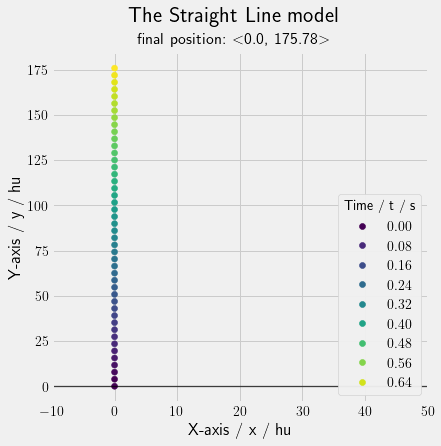

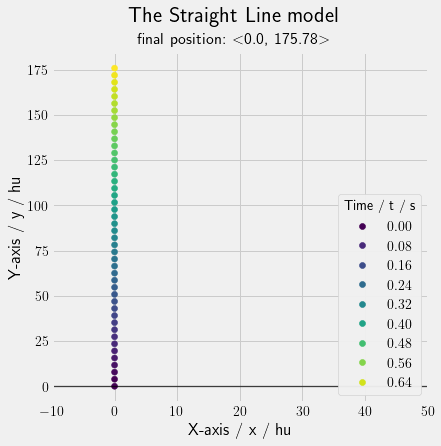

In [33]:
def nothing(t):
    return [0, 1]
    # return [math.sin(t + 0), math.cos(t + 0)]
    # return [0.583, 0.8125]


@auto_save()
def straight_nothing_1():
    pos, data = simulate_no_constraint_discrete(nothing)
    print(f"straight_nothing_1: {pos}")

    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    ts = [d[0] for d in data]
    xs = [d[1] for d in data]
    ys = [d[2] for d in data]

    sca = ax.scatter(xs, ys, c=ts)

    ax.set_xlim(-10, 50)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    legends = ax.legend(*(sca.legend_elements()),
                        loc="lower right", title="Time / t / s")
    ax.add_artist(legends)

    # add titles
    figtext(0.5, 0.95, 'The Straight Line model, no constraints', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, f'final position: $<${round(pos[0], 2)}, {round(pos[1], 2)}$>$', fontsize=16,
            ha='center')
    # ax.set_title("The Straight Line model")
    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig


@auto_save()
def straight_constraint_inequality():
    limit, data = constraint_continuous(nothing)

    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    ts = [d[0] for d in data]
    cs = [d[1] for d in data]

    line = ax.plot(ts, cs, label="RHS at time t")
    ax.plot([0, ts[-1]], [limit, limit], color='red', label="Constraint constant")
    ax.fill_between(ts, 0, limit, color='none', hatch='//', edgecolor='r')

    # ax.set_xlim(-10, 50)
    ax.axhline(y=4, color='black', linewidth=1.3, alpha=0.7)

    ax.set_ylim(4, 9)
    ax.legend()
    # add titles

    ax.set_title("Constraints of the Straight Line model")
    ax.set_xlabel("Time / t / s")
    ax.set_ylabel("Constraint / c / $\\frac{1}{A\\tau} - 1$")

    return fig

@auto_save()
def straight_constraint():
    pos, data = simulate_discrete_euler(nothing, 1 / 64)
    print(f"straight_constraint: {pos}")


    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    ts = [d[0] for d in data]
    xs = [d[1] for d in data]
    ys = [d[2] for d in data]

    sca = ax.scatter(xs, ys, c=ts)

    ax.set_xlim(-10, 50)
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    legends = ax.legend(*(sca.legend_elements()),
                        loc="lower right", title="Time / t / s")
    ax.add_artist(legends)

    # add titles
    figtext(0.5, 0.95, 'The Straight Line model', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, f'final position: $<${round(pos[0], 2)}, {round(pos[1], 2)}$>$', fontsize=16,
            ha='center')
    # ax.set_title("The Straight Line model")
    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig

# print(simulate_no_constraint_continuous(w))
# print(simulate_no_constraint_discrete(w))
# print(simulate_continuous(w))
# print(simulate_discrete(w))

# straight_nothing_1()
# straight_constraint_inequality()
straight_constraint()

In [34]:
import neat
import time
import os
import random

## MACHINE LEARNING CODE IN SCRIPTS FOLDER

In [13]:
# Step by Step functions
import cmath


def vec_rotate(a, theta):
    """
    rotate a vector by theta radians

    :param a:
    :param theta:
    :return:
    """
    return [a[0] * math.cos(theta) - a[1] * math.sin(theta),
            a[0] * math.sin(theta) + a[1] * math.cos(theta)]


def vec_mag(a):
    """
    calculate the magnitude of a vector

    :param a:
    :return:
    """
    return math.sqrt(a[0] ** 2 + a[1] ** 2)

In [29]:
# step by step functions

import cmath


def step_step_w_psi(psi):
    def step_step_w_1(t, v, j, tau):
        g, l, A, v0 = j
        LA = l * A

        r, phi = cmath.polar(v[0] + 1j * v[1])
        if phi <= psi:
            a = cmath.exp(1j * psi)
        else:
            theta = math.acos((l-LA*tau) / r)
            a = (cmath.exp((phi - theta) * 1j))
        return [a.real, a.imag]
    return step_step_w_1


def step_step_w(t, v, j, tau):
    g, l, A, v0 = j
    LA = l * A

    cutoff = 0.1 * math.pi
    r, phi = cmath.polar(v[0] + 1j * v[1])
    # if phi <= cutoff:
    #     return [0,0]

    theta = math.acos((l-LA*tau) / r)
    a = (cmath.exp((phi - theta) * 1j))
    # if a.imag < 0:
    #     return [0, 0]
    return [a.real, a.imag]

def simulate_discrete_euler_step(w, h, j=None):
    if j is None:
        j = default_j

    g, l, A, v0 = j

    tf = air_time_discrete(g, h)

    data = [[0, 0,0]]

    v = v0
    p = [0, 0]
    t = 0
    for n in range(0, math.ceil(tf / h)):

        a = w(t, v, j, h)

        gamma1 = l * A * h
        gamma2 = l - vec_dot(v, a)
        f = pos(gamma2) * (gamma2 * pos(gamma1 - gamma2) + gamma1 * pos(gamma2 - gamma1)) / h

        v = vec_add(v, vec_scale(a, h * f))
        p = vec_add(p, vec_scale(v, h))
        data.append([t, p[0], p[1]])

        t += h

    return p, data

def step_by_step(j=None):
    if j is None:
        j = default_j

    g, l, A, v0 = j

    tf = air_time_discrete(g, 1/64)
    # tf = 0.7

    # r, phi = v0[1], 0.5 * math.pi

    data = [[0, 0, 0]]
    s = [0, 0]

    v = v0[1] * cmath.exp(1j * 0.5 * math.pi)
    LA = l * A
    tau = 1/64
    for t in np.arange(0, tf+0.01, tau):
        # print(phi)
        # print(r, phi / math.pi * 180)
        # print((l-LA*tau)/r)
        # print(r, phi)
        # phi = phi + tau * (-math.acos((l-LA*tau)/r))
        # r = r + LA / r
        r, phi = cmath.polar(v)
        # TODO: find 0.20 ?
        # if phi <= 0.20 * math.pi:
        #     pass
        # else:
        theta = math.acos((l-LA*tau) / r)
        a = (LA * cmath.exp((phi - theta) * 1j))
        v += a * tau

        s = vec_add(s, vec_scale([r*math.cos(phi), r*math.sin(phi)], tau))
        data.append([t, s[0], s[1]])

    # print(vec_mag(s))
    return s, data


def graph_motion(data):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()

    ts = [d[0] for d in data]
    xs = [d[1] for d in data]
    ys = [d[2] for d in data]

    sca = ax.scatter(xs, ys, c=ts)

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    legends = ax.legend(*(sca.legend_elements()),
                        loc="lower right", title="Time / t / s")
    ax.add_artist(legends)

    ax.set_title("The Straight Line model")
    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig

# p0, data = step_by_step()
# p0, data = simulate_discrete_euler_step(step_step_w_1, 1/64)
# graph_motion(data)
# print(vec_mag(p0))
# step_by_step_1()


In [ ]:
# step by step graphing


@auto_save()
def step_by_step_1():
    pos, data = simulate_discrete_euler_step(step_step_w, 1/64)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    ts = [d[0] for d in data]
    xs = [d[1] for d in data]
    ys = [d[2] for d in data]

    sca = ax.scatter(xs, ys, c=ts)

    ax.set_xlim(-10,500)

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    legends = ax.legend(*(sca.legend_elements()),
                        loc="lower right", title="Time / t / s")
    ax.add_artist(legends)

    figtext(0.5, 0.95, 'The First Step by Step model', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, f'final position: $<${round(pos[0], 2)}, {round(pos[1], 2)}$>$', fontsize=16,
            ha='center')
    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig

@auto_save()
def step_by_step_2():
    plt.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    distances = []
    psis = np.arange(-0.5 * math.pi, 0.5 * math.pi, 0.03)
    colors = plt.cm.jet(np.linspace(0, 1, len(psis)))
    for index, psi in enumerate(psis):
        pos, data = simulate_discrete_euler_step(step_step_w_psi(psi), 1/64)
        xs = [d[1] for d in data]
        ys = [d[2] for d in data]

        distance = vec_mag(pos)
        distances.append((distance, pos, (xs, ys, colors[index]), psi))

        if index % 10 == 0:
            ax.plot(xs, ys, c=colors[index], label=str(round(psi, 2)))
        else:
            ax.plot(xs, ys, c=colors[index])

                

    ax.set_xlim(-10,500)

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    # add legends for line colors, step
    ax.legend(loc="lower right", title="$k$ / rad")

    # get best distance
    best_distance = max(distances, key=lambda x: x[0])
    mag, pos, data, k = best_distance
    xs, ys, c = data
    ax.plot(xs, ys, c='black', linewidth=6)
    ax.plot(xs, ys, c=c, linewidth=3)

    figtext(0.5, 0.95, 'The Second Step by Step model, stopping at $k$ rad', fontsize=20,
            ha='center')
    figtext(0.5, 0.9, f'best position (k={round(k, 2)}, |p|={round(mag, 2)}): $<${round(pos[0], 2)}, {round(pos[1], 2)}$>$', fontsize=16,
            ha='center')

    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig

@auto_save()
def step_by_step_2k():
    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()


    ys = []
    psis = np.arange(-0.5 * math.pi, 0.5 * math.pi, 0.001)
    for index, psi in enumerate(psis):
        pos, data = simulate_discrete_euler_step(step_step_w_psi(psi), 1/64)
        ys.append(vec_mag(pos))

    ax.plot(psis, ys)

    ax.set_ylim(170, 410)


    ax.set_title(r"The total displacement against stopping angle $k$")
    ax.set_ylabel("The total displacement / p / hu")
    ax.set_xlabel("The stopping angle $k$ / k / rad")

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
    return fig



# step_by_step_2()
# step_by_step_2k()

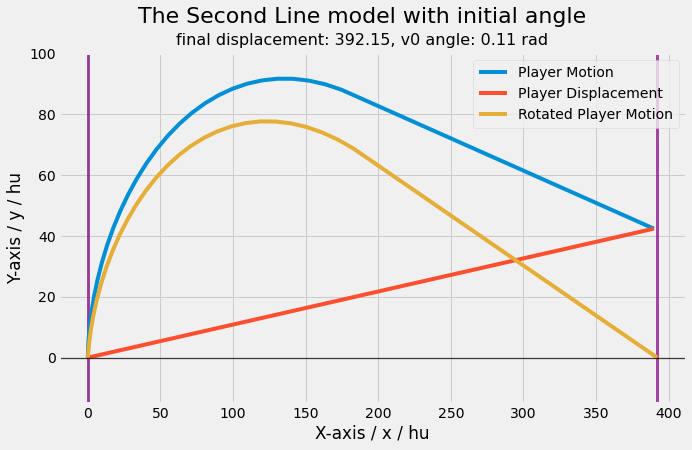

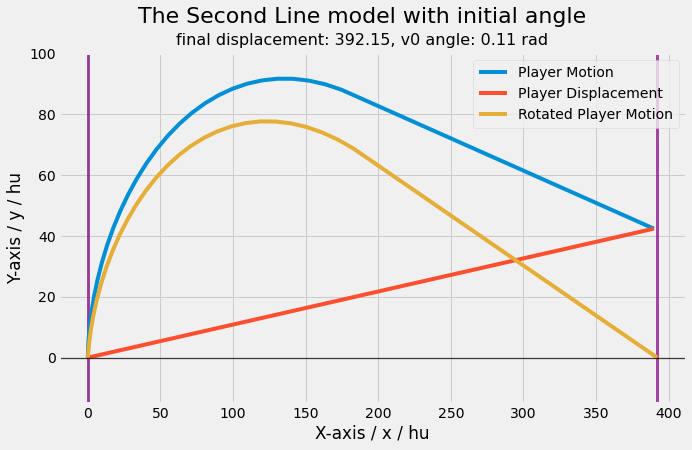

In [61]:

# find best one for ledge

def best_k(psis = None):
    if psis is None:
        psis = np.arange(-0.5 * math.pi, 0.5 * math.pi, 0.05)

    distances = []
    for index, psi in enumerate(psis):
        pos, data = simulate_discrete_euler_step(step_step_w_psi(psi), 1/64)
        distance = vec_mag(pos)
        distances.append((distance, psi))


    dist, psi = max(distances, key=lambda v: v[0])
    return psi

def better_k(psis = None):
    if psis is None:
        psis = np.arange(-0.5 * math.pi, 0.5 * math.pi, 0.05)

    distances = []
    for index, psi in enumerate(psis):
        pos, data = simulate_discrete_euler_step(step_step_w_psi(psi), 1/64)
        distance = vec_mag(pos)
        if pos[0] < 0:
            continue
        distances.append((distance, psi))


    dist, psi = max(distances, key=lambda v: v[0])
    return psi

@auto_save()
def step_by_step_edge():
    plt.rcParams['text.usetex'] = False

    best = best_k()
    # useful = better_k()

    pos, data = simulate_discrete_euler_step(step_step_w_psi(best), 1 / 64)
    mag = vec_mag(pos)

    angle = math.atan(pos[1]/pos[0])
    # TODO: draw another line and rotate

    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    rotated_data = [vec_rotate([d[1], d[2]], -angle) for d in data]

    xs = [d[1] for d in data]
    ys = [d[2] for d in data]

    ax.set_ylim(-15, 100)

    ax.axvline(x=0, color='purple', linewidth=3, alpha=0.7)
    ax.axvline(x=mag, color='purple', linewidth=3, alpha=0.7)
    ax.plot(xs, ys, label="Player Motion")

    rxs = [d[0] for d in rotated_data]
    rys = [d[1] for d in rotated_data]

    ax.plot([0, pos[0]], [0, pos[1]], label="Player Displacement")
    ax.plot(rxs, rys, label="Rotated Player Motion")


    ax.legend()

    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)

    ax.legend(loc="upper right")


    # add titles
    figtext(0.5, 0.95, 'The Second Line model with initial angle', fontsize=22,
            ha='center')
    figtext(0.5, 0.9, f'final displacement: {round(mag, 2)}, v0 angle: {round(angle,2)} rad', fontsize=16,
            ha='center')
    # ax.set_title("The Straight Line model")
    ax.set_xlabel("X-axis / x / hu")
    ax.set_ylabel("Y-axis / y / hu")

    return fig

step_by_step_edge()